### Knowledge Graphs + Code + LLMs

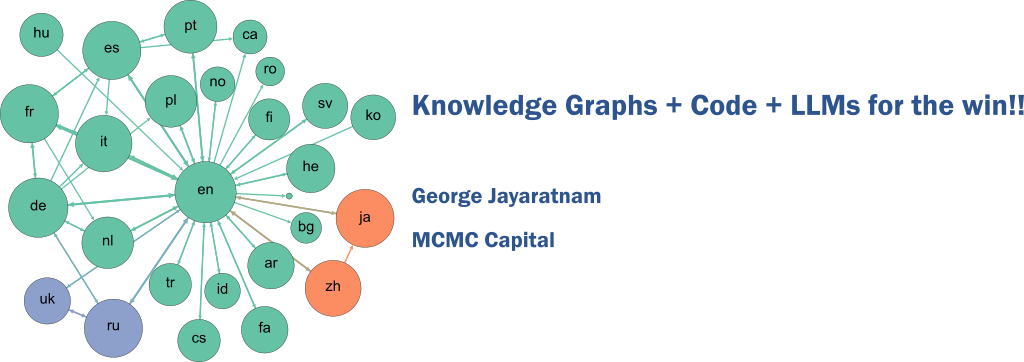

In [1]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/title.png"

# Display the PNG file
Image(filename=png_path)

### Summary

**The problem:** How to understand / piece together a large unfamiliar codebase when there is:


- Missing, scant, and sometimes inaccurate documentation
 

- Mixed use of technologies and frameworks + legacy code


- No easy way of tracking connected files, function, parameters, etc.


- No natural language explanation of code blocks
  

**The solution:** This notebook shows how to use a knowledge graph to analyse
 connected data like a large codebase.
  

Key features:
 
 
- Works primarily with metadata


- Ingest metadata into the graph quickly and start asking questions


- As more questions are triggered, the graph is progressively enhanced


- LLMs are used to help with an initial 'understanding' of what the code does


- Control over the input token limits of the LLM are managed via graph queries

 
- Demo is based on the Zotero app teardown but approach is generalisable to any 
codebase irrespective of size, language, tech stack, etc.

### Notebook summary: LLMs + Knowledge Graphs + Code

1. Knowledge graph (KG) basics
    - Basic concepts
    - Storage options


2. My use case: Improving Zotero's search capability
    - Hacking a complex codebase!
    - Knowledge graph design 


3. Part 1: A KG for the data layer
    - What are my questions
    - Buildling a knowledge graph on top of a RDBMS


4. Part 2: A KG for the application layer
    - Abstract Syntax Trees (AST)
    - Working with the Github Search API
    - LLMs to help with ***initial*** code explanations


5. Part 3: A KG for the business domain layer
    - GraphRAG for text
    - Public ontologies

   
6. Key takeways + Resources

### The big picture

###### Diagram: What I'm trying to build

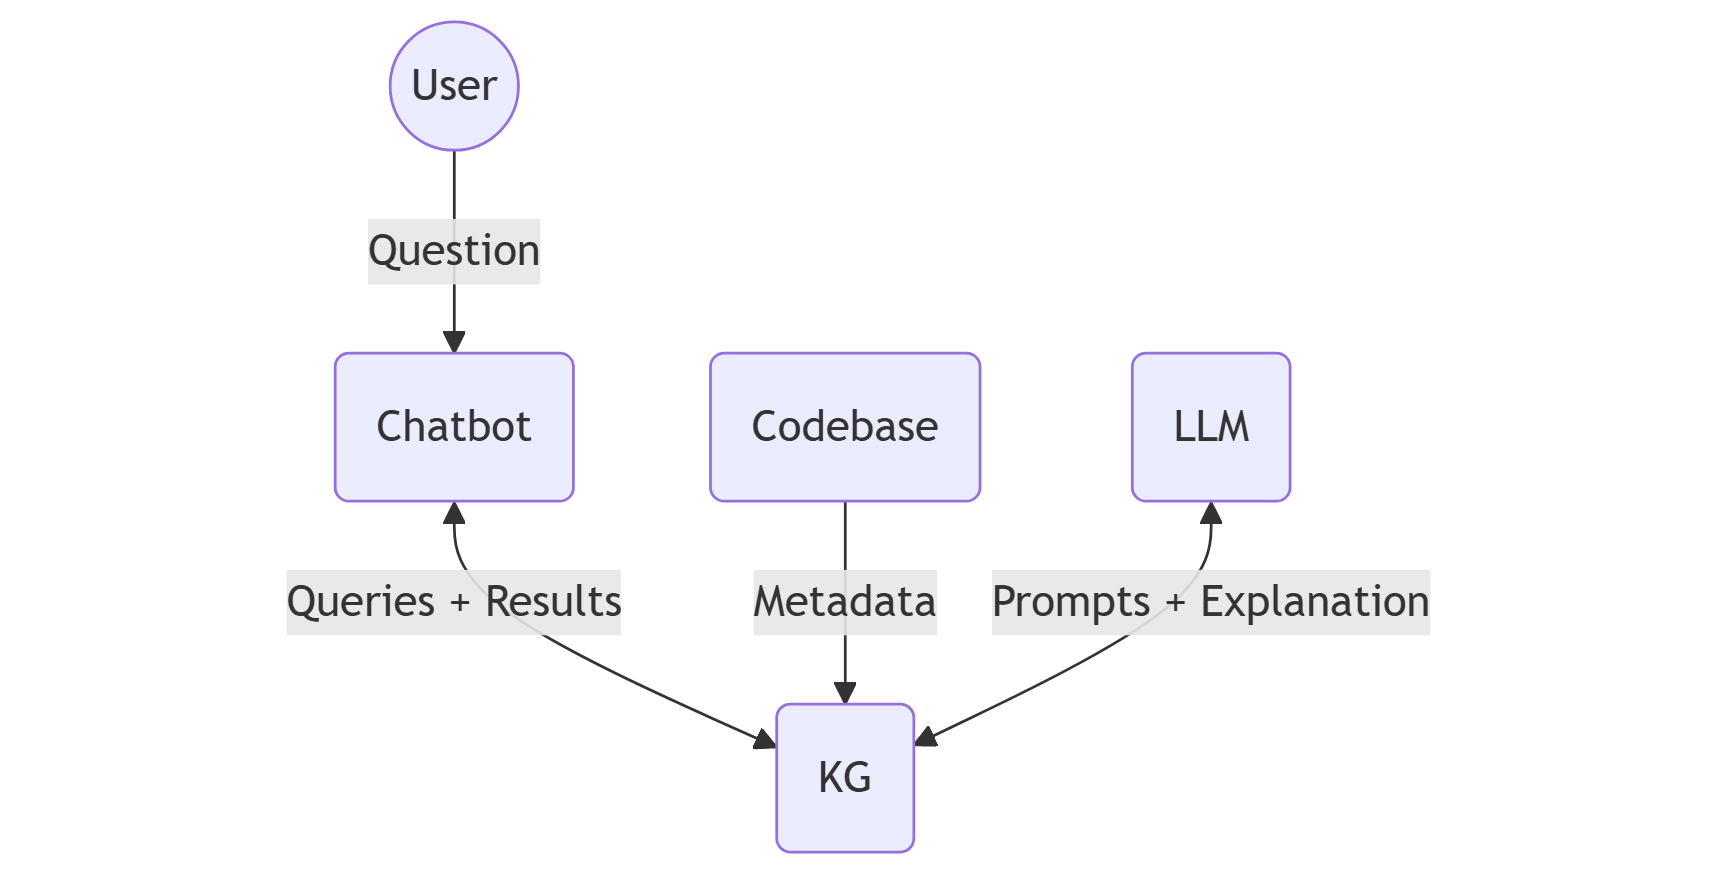

In [7]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/bigPicture.png"

# Display the PNG file
Image(filename=png_path)

This knowledge graph demo is designed to be a federation of 3 separate 
knowledge graphs:
1. Data KG (Part 1) - database schemas
2. Application KG (Part 2) - application code
3. Business Domain KG (Part 3) - text in the form of ontologies

Each KG ingests metadata from different sources and caters to questions 
about their respective layer. 

###### Diagram: Code Overview - creating the Data and Application KGs

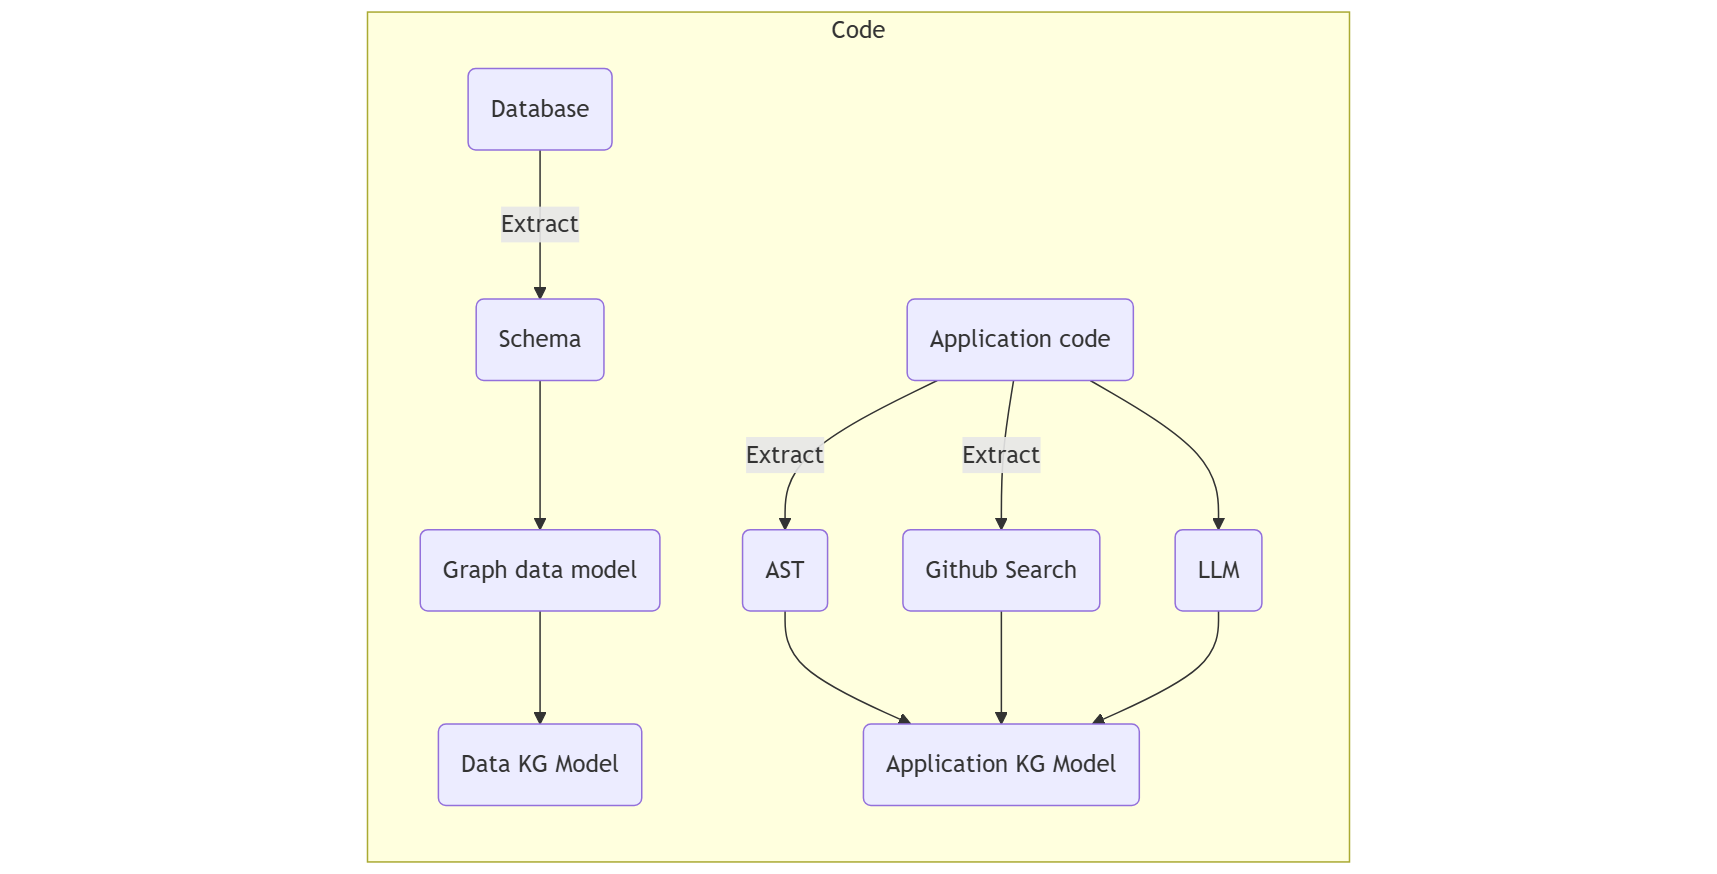

In [8]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/codeOverview.png"

# Display the PNG file
Image(filename=png_path)

###### Diagram: Unstructured data - creating the Business Domain KGs

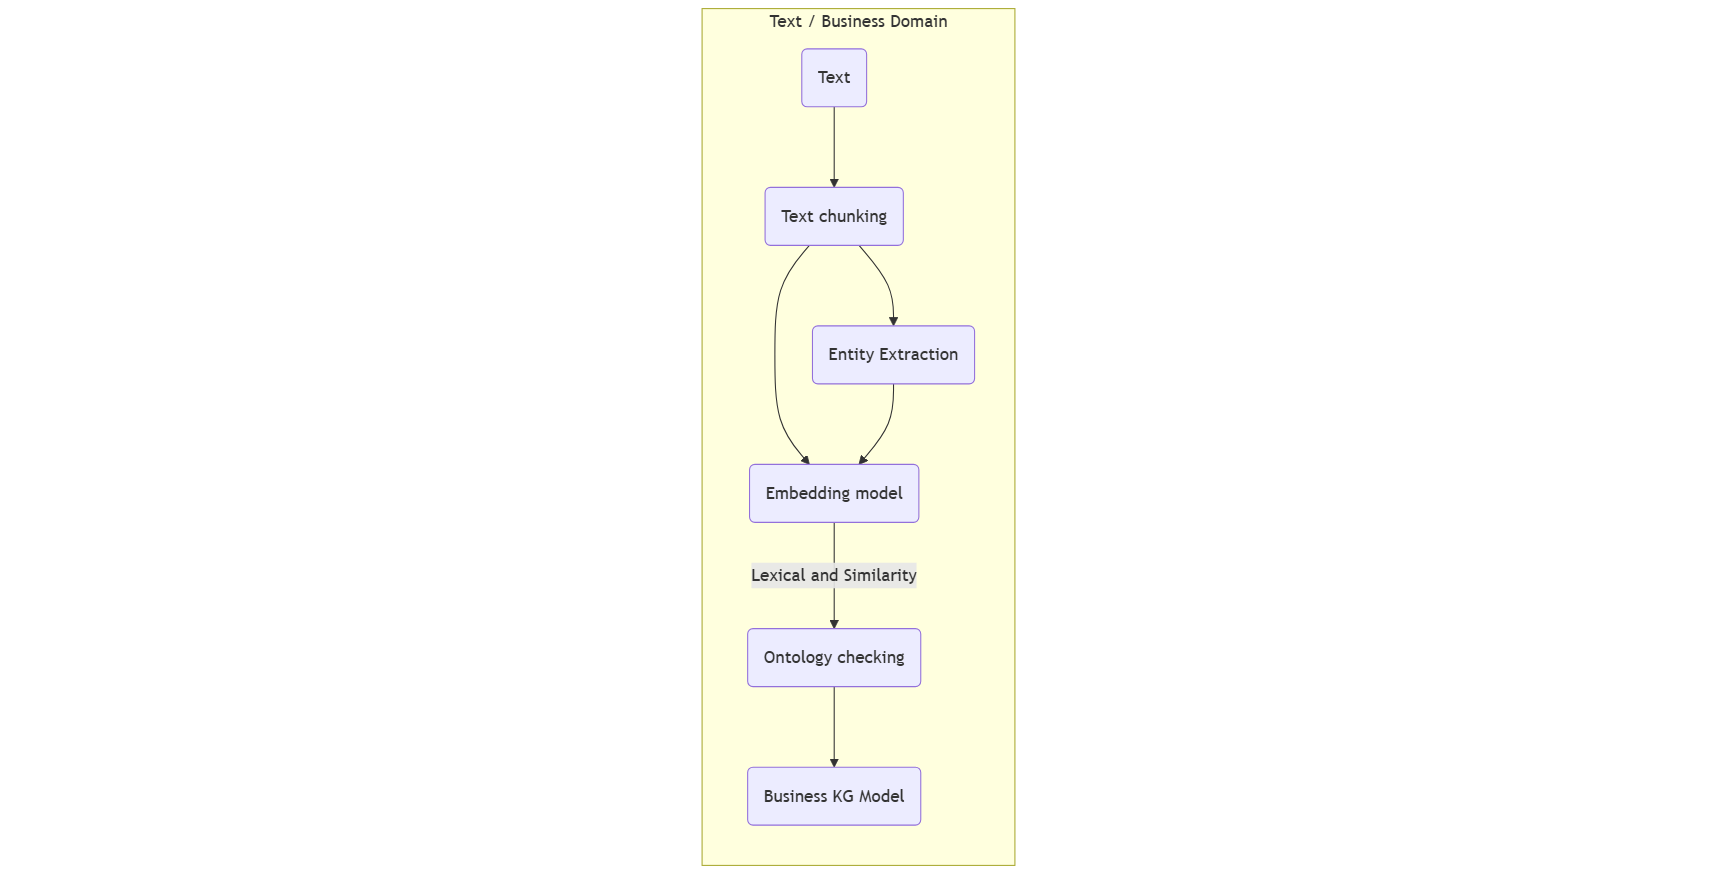

In [9]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/textOverview.png"

# Display the PNG file
Image(filename=png_path)

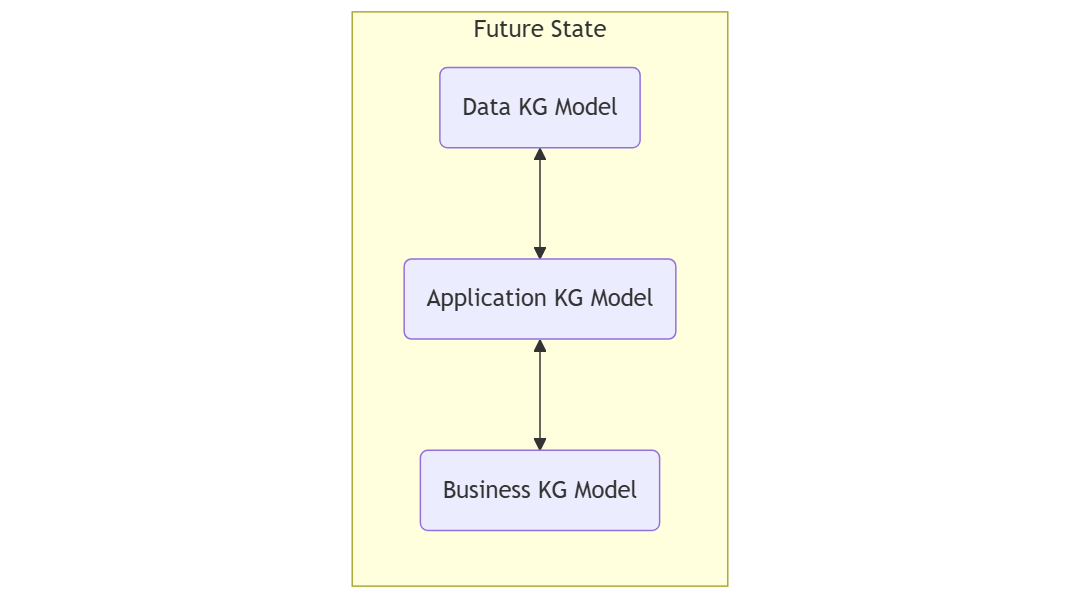

In [8]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/combined.png"

# Display the PNG file
Image(filename=png_path)

*Diagrams inspired by the work of [Paco Nathan](https://www.youtube.com/watch?v=B6_NfvQL-BE), a KG industry guru*

### 1. Knowledge graph (KG) 

###### What are knowledge graphs?

> "Knowledge graphs are a way of organizing and representing information in a machine-readable format. A knowledge graph represents a collection of real-world concepts (displayed as nodes) and relationships (displayed as edges) in the form of a graph used to link and integrate data coming from diverse sources."
> 
> `-` [data.world](https://data.world/blog/what-is-a-knowledge-graph/)


*My take* - Just a way of representing knowledge to:


1. Answer questions - given context


2. Able to be read by machines/code


3. Is accurate - logical and traceable


4. Easily updatable - new learning/refactor

#### Storage options

Many ways to store a knowledge graph:


1. Graph databases

   1. Neo4j
         
   2. Janus (open source)

   3. TigerGraph

    
2. RDF triplestores

   1. Blazegraph (Wikipedia)
   
   2. GraphDB (Ontotext)
     
   3. PoolParty


3. Elasticsearch - requires plugins


4. RDBMS - MySQL at Facebook (2004)  

#### Neo4j example 

- Graph example from Neo4j


- Data from the 
[StackOverflow Questions API](https://neo4j.com/graphgists/1a1d669d-8f35-485c-afe7-b4e0bf45d7d7/)


- Ingested into a Neo4j graph model

#### Neo4J - Why I ended up choosing them

- Build my own PageRank for contextual text search


- Started with Elasticsearch


- Neo4j easiest to get onboarded


- Free local and cloud options


- Query syntax (Cypher) similar to SQL


- Cypher moving to W3C standard - can work with other compliant graph DBs 
(SAP HANA 
Graph)

#### Neo4j example 

- Graph example from Neo4j


- Data from the 
[StackOverflow Questions API](https://neo4j.com/graphgists/1a1d669d-8f35-485c-afe7-b4e0bf45d7d7/)


- Ingested into a Neo4j graph model

###### Code: Setup environment and cypher query function

In [1]:
# Setup env and key query function
from dotenv import load_dotenv
from neo4j import GraphDatabase
import sqlite3
from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
import os
import pandas as pd
import requests
import time
import base64
import subprocess
import json
import pickle
import datetime
import pytz
import re
import ast
from langchain_openai import ChatOpenAI
from langchain_neo4j import Neo4jGraph, GraphCypherQAChain
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate
import gradio as gr

load_dotenv()

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
UN = os.getenv("NEO4J_USERNAME")
PW = os.getenv("NEO4J_PASSWORD")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")


# Define a function to run a Cypher query   
def run_cypher_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters)
        # Fetch and return the results
        return result.data()

###### Code: Stackoverflow graph schema: View, Nodes, Counts

In [2]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='stackoverflow') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

    # Query to list all nodes and their properties
    query_stack_nodes = """
    CALL db.schema.nodeTypeProperties() 
    YIELD nodeType, propertyName 
    RETURN nodeType AS label, COLLECT(propertyName) AS properties
    """
    result_query_stack_nodes = run_cypher_query(query_stack_nodes)
    df_result_query_stack_nodes = pd.DataFrame(result_query_stack_nodes)
    print(f"Results: query_stack_nodes\n{df_result_query_stack_nodes}\n")

    # Query to print a sample of 5 records from the Tag node
    query_tag_sample = """
    MATCH (t:Tag)  
    RETURN t AS tag_props 
    LIMIT 5;
    """
    result_query_tag_sample = run_cypher_query(query_tag_sample)
    df_result_query_tag_sample = pd.DataFrame(result_query_tag_sample)
    print(f"Results: query_tag_sample\n{df_result_query_tag_sample}\n")

    # Query to count the frequency of nodes
    query_stack = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """

    result_stack = run_cypher_query(query_stack)
    df_stack_nodes = pd.DataFrame(result_stack)
    # Flatten the 'label' column since it's a list
    df_stack_nodes['label'] = df_stack_nodes['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print(f"Results: df_stack_nodes['label']\n{df_stack_nodes}\n")  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Results: query_stack_nodes
         label                                         properties
0      :`User`                               [uuid, display_name]
1       :`Tag`                                       [name, link]
2    :`Answer`  [uuid, title, link, is_accepted, body_markdown...
3   :`Comment`                                [uuid, link, score]
4  :`Question`  [uuid, title, creation_date, accepted_answer_i...

Results: query_tag_sample
                                           tag_props
0  {'name': 'neo4j', 'link': 'https://stackoverfl...
1  {'name': 'subgraph', 'link': 'https://stackove...
2  {'name': 'graph', 'link': 'https://stackoverfl...
3  {'name': 'cypher', 'link': 'https://stackoverf...
4  {'name': 'graph-databases', 'link': 'https://s...

Results: df_stack_nodes['label']
      label  count
0  Question   1589
1   Comment   1396
2    Answer   1367
3      User   1365
4       Tag    476



###### Diagram: Stackoverflow schema - from code result

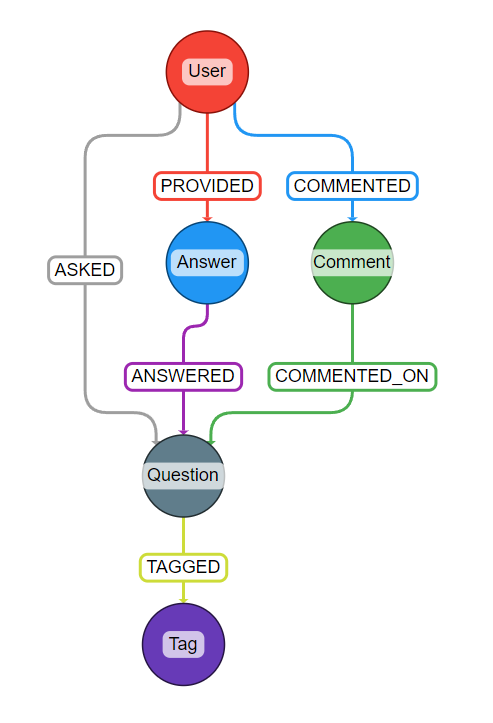

In [3]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/stackoverflow_schema.png"

# Display the PNG file
Image(filename=png_path)

So what types of questions can we answer from this schema?


**Question: "How are tags related to other tags?"**


```
    MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
    WHERE t1.name < t2.name AND t1.name <> 'neo4j' AND t2.name <> 'neo4j'
    RETURN t1.name AS TAG_1, t2.name AS TAG_2 , count(*) AS freq
    ORDER BY freq DESC LIMIT 10;
```


* Each tag is a unique instance of the `Tag` node 


Answer **requires multiple joins** via the Question Node.

###### Code: Query to calculate the frequency of the top 10 tag-pairs

In [11]:
# import pandas as pd
# from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget

with GraphDatabase.driver(URI, auth=AUTH, database='stackoverflow') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # Question: "How are tags related to other tags"
    query_tags = """
    MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
    WHERE t1.name < t2.name AND t1.name <> 'neo4j' AND t2.name <> 'neo4j'
    RETURN t1.name AS TAG_1, t2.name AS TAG_2 , count(*) AS freq
    ORDER BY freq DESC LIMIT 10;
    """

    result_tags = run_cypher_query(query_tags)
    df_result_tags = pd.DataFrame(result_tags)
    # Flatten the 'label' column since it's a list
    # df_result_4['label'] = df_result_4['label'].apply(lambda x: x[0])
    print(f"Tag-pair frequency\n{df_result_tags}\n")  # Outputs the list of tag-pair frequencies

driver.close()

Neo4j connection established.
Tag-pair frequency
    TAG_1            TAG_2  freq
0  cypher       neo4j-apoc    86
1  cypher  graph-databases    79
2  cypher            graph    46
3  cypher           python    32
4  cypher         database    30
5  cypher             java    29
6  cypher       redisgraph    27
7  py2neo           python    20
8  cypher          graphql    17
9    java           spring    17



#### Key points: Representing knowledge in a graph database

1. Both nodes and relationships can have multiple properties - numbers, text,
 dates


2. Two nodes can have multiple relationships between them


3. Graph databases have a schema but they are flexible / easy to refactor


4. Graph schema design depends on the types of questions you want to ask 


5. Suited for questions/queries where the intermediate nodes are not known - 
multi-hop


6. Pre-processing data prior to ingestion may require some effort

### 2. My use case: Improving Zotero's search capability

- Widely used citation and bibliography management tool in the academic and 
research community


- Drag-n-drop content storage (PDF, URLs, Youtube, RSS etc).


- **70+ data connectors**: PDFs, websites, wikis, aggregator sites, news sites 


- Issues with Zotero's search functionality:
    - Manual tagging - no link with ontologies
    - No in-content search - PDFs only if you sync with Zotero Cloud
    - No control over tag weights for search result ranking
    - Tag management


- Want to build my own search ranking engine on top of Zotero data

###### Diagram: What I'm trying to do

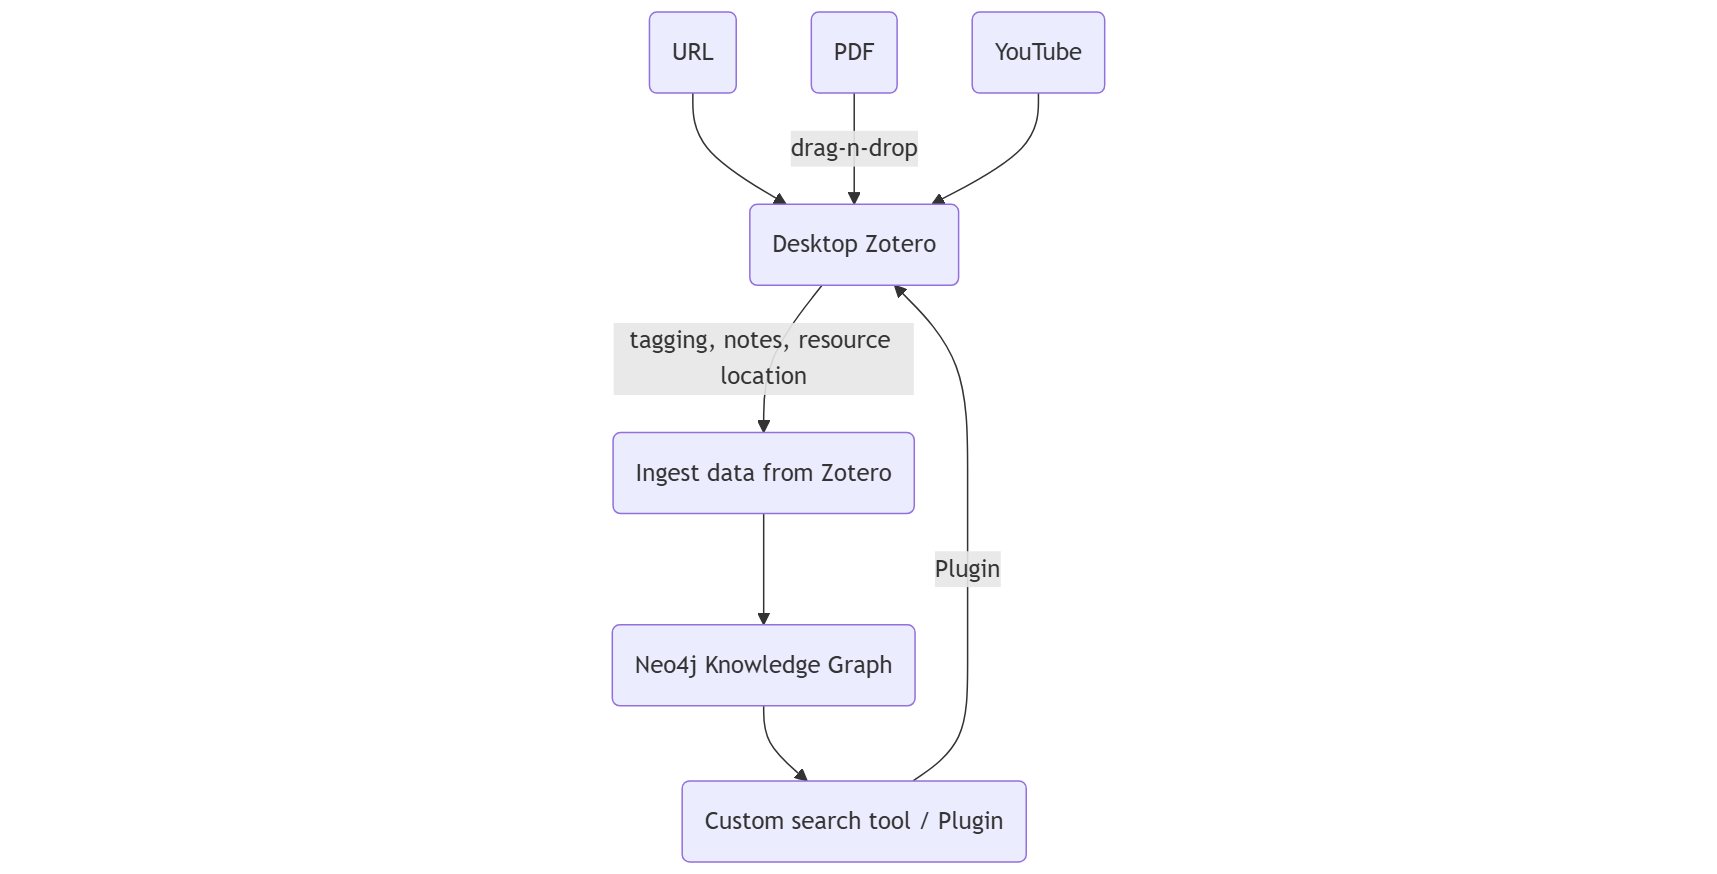

In [13]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/zoteroWorkflow.png"

# Display the PNG file
Image(filename=png_path)

###### Hacking a complex codebase: Can connected data help?

- Zotero's documentation doesn't really explain the codebase


- I need to start from ground-zero


1. What are the basics
    - How and where is the data kept?
    - How does the codebase work - any framework used?


2. How is the codebase connected right across the stack?
    - What does the data model look like?
    - How does the application talk to the database?
    - How do the various classes, functions and parameters relate to each other?  

### 3. Part 1: A KG for the data layer

#### When a DBMS is the data store, the schema + stored functions hold the key

- Zotero uses [SQLite](https://www.zotero.org/support/dev/client_coding/direct_sqlite_database_access) as its database


- However content is stored in individual hashed folders in the `Users` directory


- **My question:** How do I go from where the tags in the database to the actual location for each piece of content?


- For that I need to know:

    1. Which table holds the tags
    2. Which table holds the information about the content and its' hashed storage location
    3. **How are the tables connected?**

#### Steps to pre-process and load the SQLite schema and foreign key metadata into Neo4j:


1. Extract table and column names by merging sqlite_master table to PRAGMA 
table_info(table_name)


2. Extract foreign key info from foreign_key_list(table_name)


3. Write a script a `For loop` to run through the `table_name` list and 
output result to a `csv` file


*[Code block not shown]*

###### Diagram: Data pipeline to ingest SQLite metadata into Neo4J

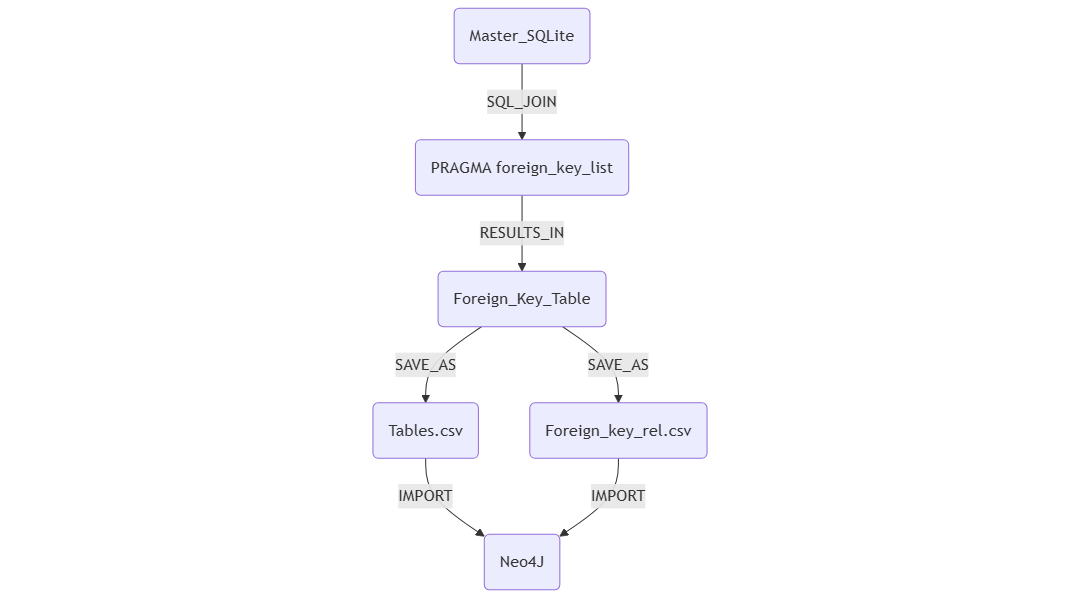

In [18]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/dataKGCodeFlow.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Connect to the db file `zotero.sqlite` for schema queries

###### Code: Check SQLite db connection

In [15]:
# Connect to the SQLite database
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")

    sqlite_select_Query = "select sqlite_version();"
    cursor.execute(sqlite_select_Query)
    record = cursor.fetchall()
    print("SQLite Database Version is: ", record)
    # Close cursor
    cursor.close()

# SQLite connection object will persist if not closed manually:
sqliteConnection.close()

# Check if cursor is still open due:
try:
    cursor.execute('SELECT 1')  # Will raise an error if connection is closed
    print("Cursor still open.")
except sqlite3.ProgrammingError:
    print("Cursor closed.")

# Check if connection is closed:
try:
    sqliteConnection.execute('SELECT 1')  # Will raise an error if connection is closed
    print("Connection still open.")
except sqlite3.ProgrammingError:
    print("SQLite connection is closed.")

Connected to Zotero SQLite
SQLite Database Version is:  [('3.45.3',)]
Cursor closed.
SQLite connection is closed.


###### Code: Extract data dictionary from `sqlite_master` table

In [17]:
# If the Zotero application is open, the database will be locked. Close it first.

# Create new SQLite connection
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")
    cursor.execute('PRAGMA table_info(sqlite_master);')
    columns = [column[1] for column in cursor.fetchall()]
    print(f"List of columns:\n{columns}\n")

    # Frequency count of type column
    query_schema_obj = """
        SELECT type, COUNT(*) AS frequency
        FROM sqlite_master
        GROUP BY type
        
        UNION ALL

        SELECT 'Total', COUNT(*)
        FROM sqlite_master
    """
    df_schema_obj_count = pd.read_sql_query(query_schema_obj, sqliteConnection)
    print(f"Frequency count of schema objects:\n{df_schema_obj_count}\n")

    # Close cursor
    cursor.close()

# Close connection    
sqliteConnection.close()
print("SQLite connection closed")

Connected to Zotero SQLite
List of columns:
['type', 'name', 'tbl_name', 'rootpage', 'sql']

Frequency count of schema objects:
      type  frequency
0    index         84
1    table         61
2  trigger         12
3    Total        157

SQLite connection closed


###### Code: Query (Neo4j) to view schema, count nodes

In [19]:
with GraphDatabase.driver(URI, auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # Query to count nodes and relationships in Neo4j
    query_sqlite_nodes = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """
    result_query_sqlite_nodes = run_cypher_query(query_sqlite_nodes)
    # Convert the list of dictionaries to a pandas DataFrame
    df_result_query_sqlite_nodes = pd.DataFrame(result_query_sqlite_nodes)
    # Flatten the 'label' column since it's a list
    df_result_query_sqlite_nodes['label'] = df_result_query_sqlite_nodes['label'].apply(
        lambda x: x[0] if len(x) > 0 else None)
    print(f"Frequency count of node:\n{df_result_query_sqlite_nodes}\n")  # Outputs the list of nodes
    print(f"Check table count is the same as SQLite metadata query.\n")

    query_sqlite_relationships = """
    MATCH ()-[r]->()
    RETURN type(r) AS relationshipType, COUNT(r) AS frequency
    ORDER BY frequency DESC;
    """

    result_query_sqlite_relationships = run_cypher_query(query_sqlite_relationships)
    df_result_query_sqlite_relationships = pd.DataFrame(result_query_sqlite_relationships)
    print(
        f"Frequency count of relationship:\n{df_result_query_sqlite_relationships}\n")  # Outputs the list of relationships

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

# Close the driver
driver.close()

Neo4j connection established.
Frequency count of node:
    label  count
0  Column    115
1   Table     61

Check table count is the same as SQLite metadata query.

Frequency count of relationship:
  relationshipType  frequency
0       HAS_COLUMN        236
1         CHILD_FK         63
2        PARENT_FK         22



GraphWidget(layout=Layout(height='500px', width='100%'))

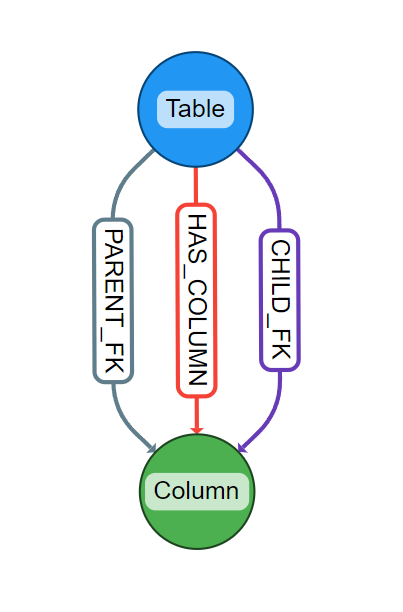

In [14]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/dataKGSchema.png"

# Display the PNG file
Image(filename=png_path)

#### The graph model can now answer questions about how tables are connected

For example:


What's the shortest join path between the **'tags'** and **'items'** tables?


*Table names chosen as the data answers my original question:*
 
**How do I go from where the tags in the database to the actual location for each piece of 
content?**

###### Code: Query Neo4j to see how 2 tables are connected

In [20]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # The shortest join path between the 'tags' and 'items' tables
    query_path = """
    MATCH path = shortestPath((t1:Table {name: 'tags'})-[:PARENT_FK|CHILD_FK*]-(t2:Table {name: 'items'}))
    RETURN path;
    """
    
    result_path = run_cypher_query(query_path)
    
    if len(result_path) == 0:
        print("No paths were returned.")
    else:
        result_path_df = pd.DataFrame(result_path)
        print(f"Full path result:\n{result_path_df}\n")
        # Generate graph from Cypher query
        g = Neo4jGraphWidget(driver)
        g.show_cypher(query_path)

# Close the driver
driver.close()

Neo4j connection established.
Full path result:
                                                path
0  [{'name': 'tags'}, PARENT_FK, {'name': 'tagID'...



GraphWidget(layout=Layout(height='500px', width='100%'))

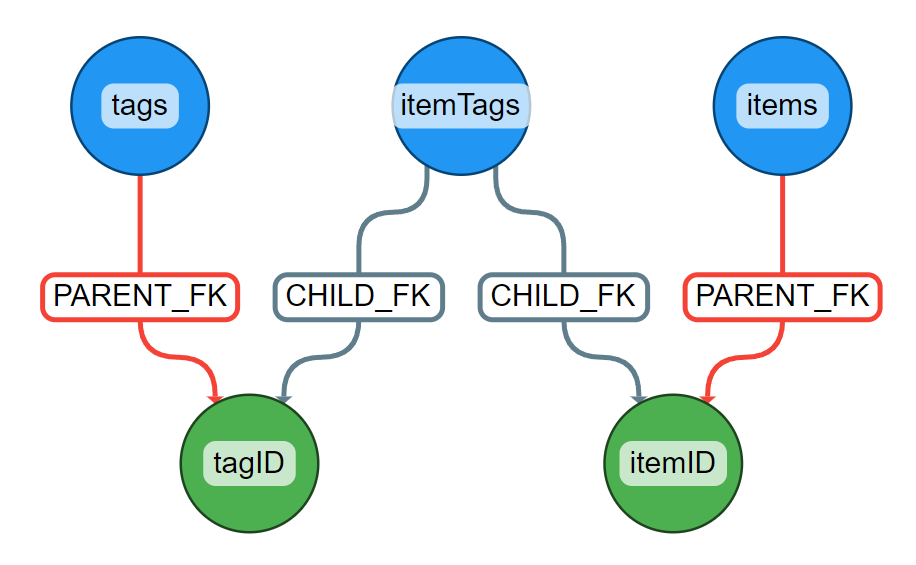

In [21]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/tagsToItemShortestPath.png"

# Display the PNG file
Image(filename=png_path)

#### Results summary

- The 'tags' and 'items' tables were specifically chosen given our initial business requirement


- Other join paths are possible by modifying the query - Cypher is designed to make graph traversal queries simple


- Can be extended to investigate other table joins

#### Overlay a chatbot to query the Data KG

Solving Data KG queries involves 3 steps:


1. What are the list of tables in the database?


2. What data does each selected table have?


3. What is the shortest join path for the 2 selected tables?

###### Code: 1. List of tables in the Data KG

In [2]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Connection established.")
       
    query_table_list = """
    MATCH (t:Table)
    RETURN t;
    """
    result_query_table_list = run_cypher_query(query_table_list)
    # print(f'Current contents of:\n{result_query_table_list}\n')
    
    
    # Convert the list of dictionaries to a pandas DataFrame
    df_result_query_table_list = pd.DataFrame(result_query_table_list)
    # Flatten the 'label' column since it's a list
    table_name_list = df_result_query_table_list['t'].apply(lambda x: x["name"]).tolist()
    print(f'List of table names:\n{table_name_list}\n')


Connection established.
List of table names:
['version', 'baseFieldMappings', 'baseFieldMappingsCombined', 'charsets', 'collectionItems', 'collectionRelations', 'collections', 'creatorTypes', 'creators', 'customBaseFieldMappings', 'customFields', 'customItemTypeFields', 'customItemTypes', 'dbDebug1', 'deletedCollections', 'deletedItems', 'deletedSearches', 'feedItems', 'feeds', 'fieldFormats', 'fields', 'fieldsCombined', 'fileTypeMimeTypes', 'fileTypes', 'fulltextItemWords', 'fulltextItems', 'fulltextWords', 'groupItems', 'groups', 'itemAnnotations', 'itemAttachments', 'itemCreators', 'itemData', 'itemDataValues', 'itemNotes', 'itemRelations', 'itemTags', 'itemTypeCreatorTypes', 'itemTypeFields', 'itemTypeFieldsCombined', 'itemTypes', 'itemTypesCombined', 'items', 'libraries', 'proxies', 'proxyHosts', 'publicationsItems', 'relationPredicates', 'retractedItems', 'savedSearchConditions', 'savedSearches', 'settings', 'storageDeleteLog', 'syncCache', 'syncDeleteLog', 'syncObjectTypes', 'sy

###### Code: Get a sample of 5 record for a selected table

In [5]:
# Create new SQLite connection
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")
    
    table_name = 'tags'  # Set the table name dynamically from Gradio selection
    print(f"Table name: {table_name}")
    
    # Dynamically construct the SQL query
    query = f"SELECT * FROM {table_name} LIMIT 5"
    
    cursor.execute(query)
    
    # Fetch column names
    columns = [desc[0] for desc in cursor.description]
    
    rows = cursor.fetchall()
    
    # Convert to Pandas DataFrame (optional)
    df_query_rows = pd.DataFrame(rows, columns=columns)
    print(df_query_rows)

    # Close cursor
    cursor.close()

# Close connection
sqliteConnection.close()
print("SQLite connection closed")

Connected to Zotero SQLite
Table name: tags
   tagID                name
0      1       manufacturing
1      2                 CPD
2      3  government program
3      4            robotics
4      5        productivity
SQLite connection closed


###### Code: Gradio chatbot to view table records

- To determine which tables are of interest

In [6]:
from IPython.display import display, Javascript

# Define a function that takes the selected item from the dropdown
def select_item(selected_table):
    
    # Create new SQLite connection
    with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
        cursor = sqliteConnection.cursor()
        # print("Connected to Zotero SQLite")
               
        # Dynamically construct the SQL query
        query = f"SELECT * FROM {selected_table} LIMIT 5"
        
        cursor.execute(query)
        
        # Fetch column names
        columns_gradio = [desc[0] for desc in cursor.description]
        
        rows_gradio = cursor.fetchall()
        
        # Convert to Pandas DataFrame (optional)
        df_query_rows_gradio = pd.DataFrame(rows_gradio, columns=columns_gradio)
        # print(df_query_rows_gradio)

        # Close cursor
        cursor.close()

    # Close connection
    # print("SQLite connection closed")
    
    return df_query_rows_gradio

# Create a Gradio Interface with a dropdown
demo = gr.Interface(
    fn=select_item, #Funtion to call
    inputs=gr.Dropdown(choices=table_name_list, label="Choose table:"),  # Dropdown input
    outputs=[gr.Dataframe(label="First 5 rows:")],                 # Output will be the selected option text
    flagging_mode="never",               # This disables flagging in Gradio 5+
    title="View individual table records",  # Title heading at the top of the interface
    live=False  # Disable live updates, so you have to submit manually
)

demo.launch(inline=True)  # Disable flagging button

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


###### Diagram: Gradio chatbot to view first 5 rows of selected table

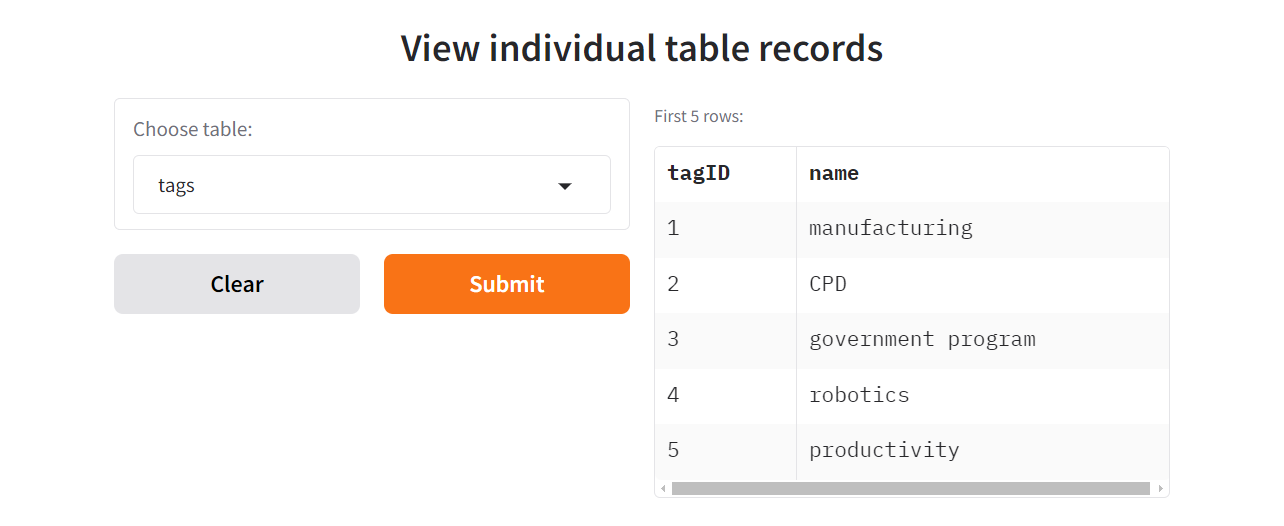

In [7]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"D:\Projects\AICampTalk\Diagrams\PNG\gradioFirst5Rows.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Gradio chatbot to select 2 tables to see their shortest path 

In [11]:
# Global dictionary to store selections
global_state = {"selected_table_1": None, "selected_table_2": None}

# Define a function for chatbot response
def chatbot_response(t1_selection, t2_selection):
    
    #Set selected tables to global state variables 
    global_state["selected_table_1"] = t1_selection
    global_state["selected_table_2"] = t2_selection
    
    return f"Run the next cell to get the join info for `{t1_selection}` and `{t2_selection}`."

# Create Gradio Interface with two independent dropdowns
demo = gr.Interface(
    fn=chatbot_response,  # Function to call
    inputs=[
        gr.Dropdown(choices=table_name_list, label="Table 1:"),  # First table dropdown
        gr.Dropdown(choices=table_name_list, label="Table 2:"),  # Second table dropdown for
    ],  # Inputs
    outputs=gr.Textbox(label="Selected tables:"),  # Text output for the response
    flagging_mode="never",
    title="Select tables for shortest join path",  # Title of the interface
)

# Launch the Gradio interface
demo.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


###### Diagram: Gradio chatbot to select 3 tables for shortest join path

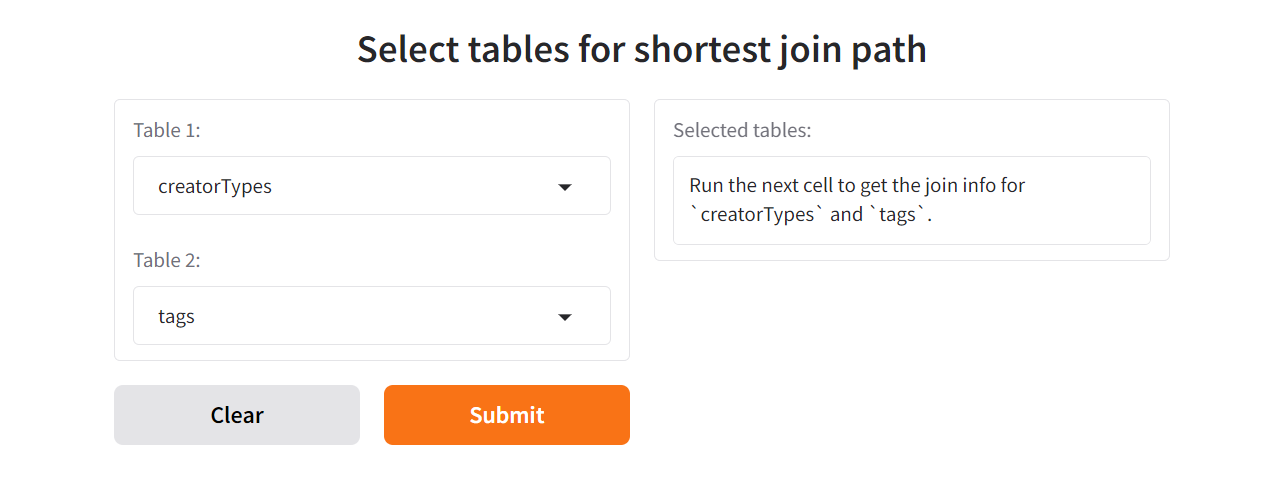

In [14]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"D:\Projects\AICampTalk\Diagrams\PNG\gradioSelect2tables.png"

# Display the PNG file
Image(filename=png_path)

In [13]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")
    
    # Access the stored values
    selected_table_1 = global_state["selected_table_1"]
    selected_table_2 = global_state["selected_table_2"]
    
    print(f"Table 1: {selected_table_1}")
    print(f"Table 2: {selected_table_2}")
    
    # The shortest join path between the 'tags' and 'items' tables
    query_path = f"""
    MATCH path = shortestPath((t1:Table {{name: '{selected_table_1}'}})-[:PARENT_FK|CHILD_FK*]-(t2:Table {{name: '{selected_table_2}'}}))
    RETURN path;
    """
    
    result_path = run_cypher_query(query_path)
    
    if len(result_path) == 0:
        print("No paths were returned.")
    else:
        result_path_df = pd.DataFrame(result_path)
        print(f"Full path result:\n{result_path_df}\n")
        # Generate graph from Cypher query
        g = Neo4jGraphWidget(driver)
        g.show_cypher(query_path)

# Close the driver
driver.close()

Neo4j connection established.
Table 1: creatorTypes
Table 2: tags
Full path result:
                                                path
0  [{'name': 'creatorTypes'}, PARENT_FK, {'name':...



GraphWidget(layout=Layout(height='500px', width='100%'))

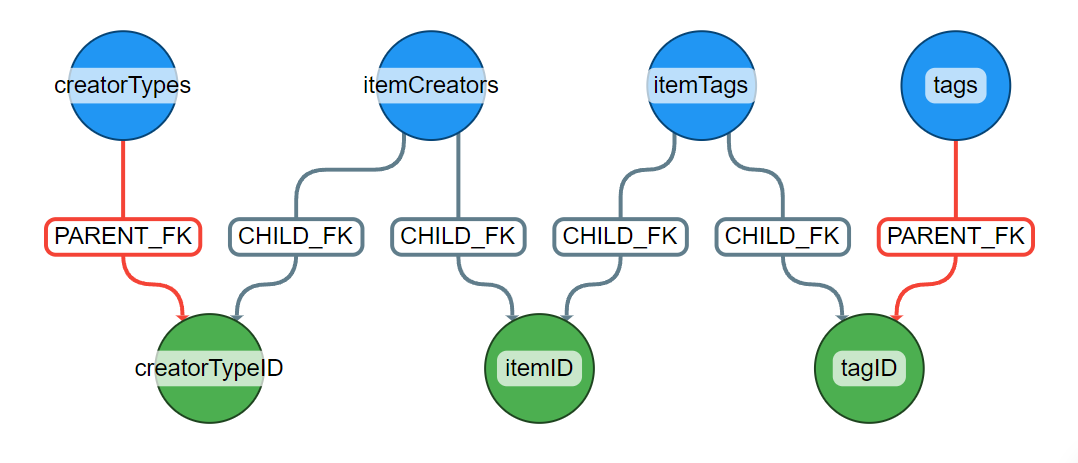

In [158]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/creatorTypesToTagsShortestPath.png"

# Display the PNG file
Image(filename=png_path)

#### Key takeaway from creating a Data KG

1. Doesn't rely on documentation


2. Read and ingest directly from metadata


3. A few lines of code to do the ETL and Cypher query design


4. Immediately see the shortest join path between tables


5. Other join patterns can be specified by modifying the cypher query 


6. Works for all types of databases and datastores



### 4. Part 2: A KG for the application layer

#### What do we know about the application code?

Unfortunately from Zotero's own documentation:


> The Zotero JavaScript API is under-documented, and at present requires a lot of looking around in the source code. The most useful parts of the source code are in chrome/content/zotero/xpcom and xpcom/data, and the chrome/content/zotero (particularly zoteroPane.js and fileInterface.js).


But there is metadata for code!


Two major sources of metadata info:


1. Github API - for repo metadata
     
    - Overall repo metrics, filetypes, etc.
 
 
2. The `Abstract Syntax Tree` (AST) - for functions, variables, imports at 
file-level
     
    - Similar approach to static analysis tools like `Semgrep`, `CodeQL` and `Sourcegraph`.

#### Start with a first version of our KG schema - what questions do we want answered

- What types of files are in the repo?


- Can I detect a framework?


- Which language contains the application logic?


- How can I find out what each file and function does?

###### Diagram: KG schema design for the application layer

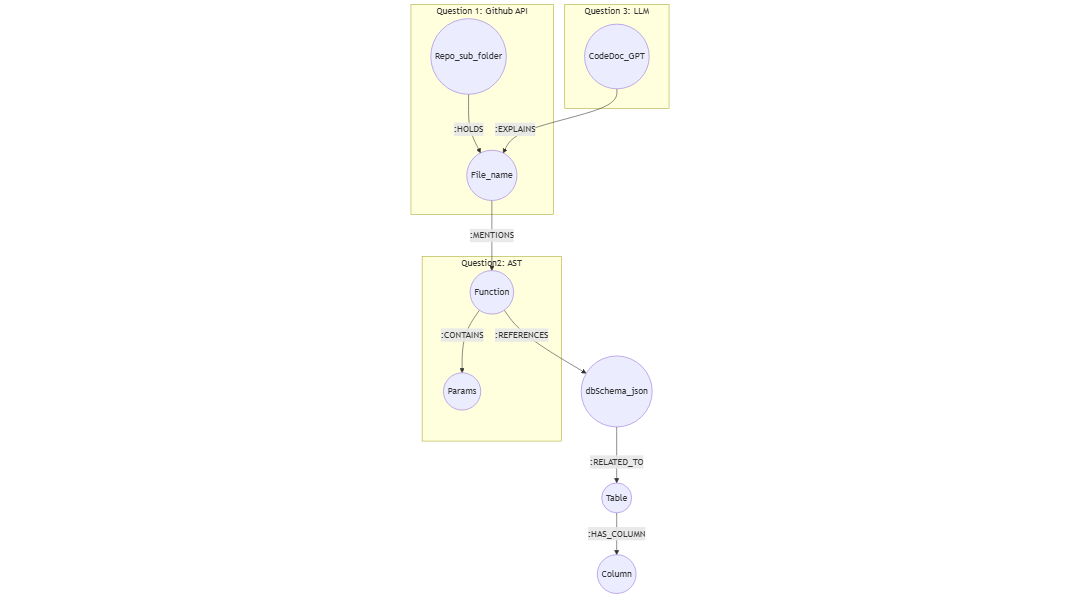

In [15]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appCodeSchemaDesign.png"

# Display the PNG file
Image(filename=png_path)

#### Repo metadata query will help with answers to the the first 3 questions:

- repo in Github: query via Github APIs
    - repo is too large to be analysed locally
    - KGs should only deal with metadata


- output query results to a CSV file


- upload to neo4j to build the base to analyse relationships

###### Diagram: Schematic of what the code is doing

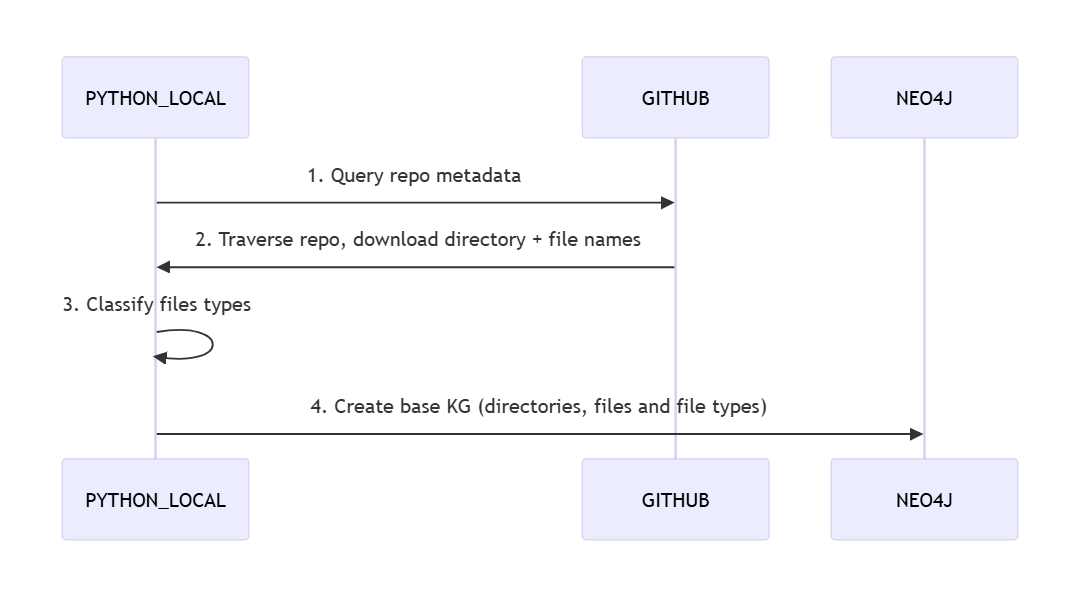

In [16]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appCodeWorkFlow1.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Query Github API to determine what's in the repo:

In [17]:
def get_github_repo_metadata(owner, repo):
    repo_url = f"https://api.github.com/repos/{owner}/{repo}"

    # Fetch repository metadata
    response = requests.get(repo_url)

    if response.status_code == 200:
        data = response.json()
        default_branch = data.get("default_branch", "main")  # Default to 'main' if not found

        # Fetch repository contents (all files and directories)
        contents_url = f"https://api.github.com/repos/{owner}/{repo}/git/trees/{default_branch}?recursive=1"
        contents_response = requests.get(contents_url)

        file_count = 0
        dir_count = 0

        if contents_response.status_code == 200:
            contents_data = contents_response.json()
            for item in contents_data.get("tree", []):
                if item["type"] == "blob":
                    file_count += 1
                elif item["type"] == "tree":
                    dir_count += 1

        metadata = {
            "Name": data.get("name"),
            "Full Name": data.get("full_name"),
            "Description": data.get("description"),
            # "Owner": data["owner"]["login"] if "owner" in data else None,
            "Visibility": data.get("visibility"),
            "Default Branch": default_branch,
            #"Stars": data.get("stargazers_count"),
            # "Forks": data.get("forks_count"),
            # "Watchers": data.get("watchers_count"),
            # "Open Issues": data.get("open_issues_count"),
            # "Created At": data.get("created_at"),
            # "Updated At": data.get("updated_at"),
            # "License": data["license"]["name"] if data.get("license") else "No License",
            "Programming Language": data.get("language"),
            "Size (KB)": data.get("size"),
            "URL": data.get("html_url"),
            "Number of Directories": dir_count,
            "Number of Files": file_count,
        }
        return metadata
    else:
        return f"Error: Unable to fetch data. Status code {response.status_code}"


# Example usage
owner = "zotero"
repo = "zotero"
repo_metadata = get_github_repo_metadata(owner, repo)

# Print the metadata
for key, value in repo_metadata.items():
    print(f"{key}: {value}")

Name: zotero
Full Name: zotero/zotero
Description: Zotero is a free, easy-to-use tool to help you collect, organize, annotate, cite, and share your research sources.
Visibility: public
Default Branch: main
Programming Language: JavaScript
Size (KB): 219055
URL: https://github.com/zotero/zotero
Number of Directories: 361
Number of Files: 3199


###### Code: Classify each accessible file in the repo

In [19]:
# GitHub API Authentication (Set your personal access token here)
HEADERS = {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}

# File extension classification dictionary
file_types = {
    ".py": "Python Script",
    ".md": "Markdown",
    ".txt": "Text",
    ".json": "JSON",
    ".csv": "CSV",
    ".html": "HTML",
    ".js": "Javascript",
    ".css": "CSS",
    ".java": "Java",
    ".cpp": "C++",
    ".c": "C",
    ".h": "Header",
    ".sh": "Shell",
    ".jpg": "JPG",
    ".jpeg": "JPEG",
    ".gif": "GIF",
    ".svg": "SVG",
    ".ico": "ICO",
    ".pyi": "Python_Image",
    ".pyw": "Python_Web",
    ".pyx": "Python_Xml",
    ".bmp": "BMP",
    ".ts": "Typescript",
    ".ipynb": "Jupyter",
    ".ftl": "FreeMarker_Java_template",
    ".dtd": "DTD_XML_def",
    ".properties": "Java_prop",
    ".xhtml": "XHTML",
    ".xml": "XML",
    ".jsx": "Javascript",
    ".yml": "YAML",
    ".gitignore": ".gitignore",
    ".gitmodules": ".gitmodules",
    ".ini": ".ini",
    ".manifest": ".manifest",
    ".jsm": ".jsm",
    ".rdf": "RDF",
    ".zip": "ZIP",
    ".pdf": "PDF",
    ".sqlite": "SQLite",
    ".png": "PNG",
    ".epub": "Epub",
    ".opf": "OPF",
    ".lua": "LUA",
    ".opml": "OPML",
    ".rss": "RSS",
    ".atom": "ATOM",
    ".xpi": "XPI",
    ".csl": "CSL",
    ".scss": "CSS",
    ".woff": "WOFF",
    ".sql": "SQL",
    ".vbs": "VBScript",
    ".idl": "IDL",
    ".mjs": "Javascript",
    ".xul": "XUL",
    ".nsi": "NSI",
    ".nsh": "NSH",
    ".rc": "RC",
    ".nlf": "NLF",
    "": "NONE"
}


# Function to fetch and classify files from a GitHub repository
def classify_files_by_extension(owner, repo, path="", retries=3):
    classified_files = []
    url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"

    for attempt in range(retries):
        response = requests.get(url, headers=HEADERS)

        # Handle rate limiting
        if response.status_code == 403 and "X-RateLimit-Remaining" in response.headers:
            reset_time = int(
                response.headers.get("X-RateLimit-Reset", time.time()))
            wait_time = max(reset_time - time.time(),
                            60)  # Wait until reset or at least 60 sec
            print(f"Rate limited. Sleeping for {wait_time} seconds...")
            time.sleep(wait_time)
            continue

        if response.status_code == 200:
            contents = response.json()
            for item in contents:
                if item["type"] == "file":
                    file_name = item["name"]
                    ext = os.path.splitext(file_name)[1]
                    file_type = file_types.get(ext, "Unknown file type")
                    file_path = item["path"]
                    classified_files.append(
                        {"File Type": file_type,
                         "Directory": os.path.dirname(file_path),
                         "File Name": file_name})
                elif item["type"] == "dir":  # Recursively traverse directories
                    classified_files += classify_files_by_extension(owner, repo,
                                                                    item[
                                                                        "path"],
                                                                    retries=retries)

            return classified_files
        else:
            print(f"Error: {response.status_code} - {response.text}")
            if attempt < retries - 1:
                print(f"Retrying... ({attempt + 1}/{retries})")
                time.sleep(5)  # Wait 5 sec before retrying
            else:
                return []


# Function to save results to Pandas and CSV
def save_to_pandas(classified_files, output_csv="repo_files.csv"):
    df_repo_files_all = pd.DataFrame(classified_files)
    df_repo_files_all.to_csv(output_csv, index=False, encoding="utf-8")

    # Compute frequency count of files by type
    file_type_counts = df_repo_files_all["File Type"].value_counts()

    print(f"Results saved to {output_csv}")
    print("\nFile Type Frequency Count:")
    print(file_type_counts)

    return df_repo_files_all, file_type_counts


# Example usage
owner = "zotero"  # Change to the repository owner
repo = "zotero"  # Change to the repository name

classified_files = classify_files_by_extension(owner, repo)
if classified_files:
    df_repo_files_all, file_type_counts = save_to_pandas(classified_files)

Results saved to repo_files.csv

File Type Frequency Count:
File Type
SVG                         713
Javascript                  483
FreeMarker_Java_template    482
DTD_XML_def                 482
Java_prop                   194
CSS                         189
Header                      107
NONE                         78
C++                          77
JSON                         58
XHTML                        52
PNG                          41
.jsm                         25
HTML                         24
Unknown file type            24
PDF                          18
Text                         15
Shell                        12
IDL                          10
GIF                           7
Epub                          7
RSS                           7
NSH                           7
XUL                           6
RC                            6
Typescript                    5
Markdown                      5
NSI                           5
SQL                           4
XM

#### Results Summary: Repo metadata stats

1. Repo Size (KB): 219055


2. Number of Directories: 361


3. Number of Files: 3199


| Filetype                 | No.  | Percentage (%) |
|--------------------------|------|----------------|
| SVG                      | 713  | 22%            |
| Javascript               | 483  | 15%            |
| FreeMarker_Java_template | 482  | 15%            |
| DTD_XML_def              | 482  | 15%            |
| Java_prop                | 194  | 6%             |
| CSS                      | 189  | 6%             |
| Header                   | 107  | 3%             |
| Others                   | 549  | 17%            |
| ------------------------ | ---- | -------------- |
| Total                    | 3199 | 100%           |

#### Import what we know into Neo4j: KGs are built progressively

- directories, file names and file types form the base of the App KG